In [2]:
import torch
import torch.nn as nn
import torchvision

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [4]:
BATCH_SIZE = 64

trainset = torchvision.datasets.CIFAR10(
    root="../data",
    train=True,
    transform=transform,
    download=True
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(trainloader)
data_iter = iter(trainloader)
im , la = next(data_iter)
print(im.shape)
print(la.shape)
print(torch.unique(la))


testset = torchvision.datasets.CIFAR10(
    root=".//data",
    train=False,
    transform=transform,
    download=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s] 


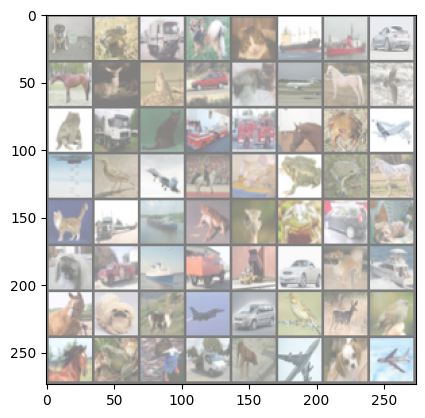

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 のクラスラベル
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 画像を表示する関数
def imshow(img):
    img = img / 2 + 0.5  # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
iterater = iter(trainloader)
images, labels = next(iterater)
# 画像を表示
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,10)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [7]:
import matplotlib.pyplot as plt

trainloss = []
trainacc = []

#可視化ができる訓練関数

def train(model, trainloader, criterion, optimizer, num_epochs=5, device="cpu"):
    global trainacc, trainloss
    trainloss = []
    trainacc = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = correct / total
        trainloss.append(epoch_loss)
        trainacc.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2%}")

    print("Training complete!")

In [9]:
#描画する
model = NN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#train(model, trainloader, criterion, optimizer, num_epochs=5, device="cuda" if torch.cuda.is_available() else "cpu")

[1.885432812716345]


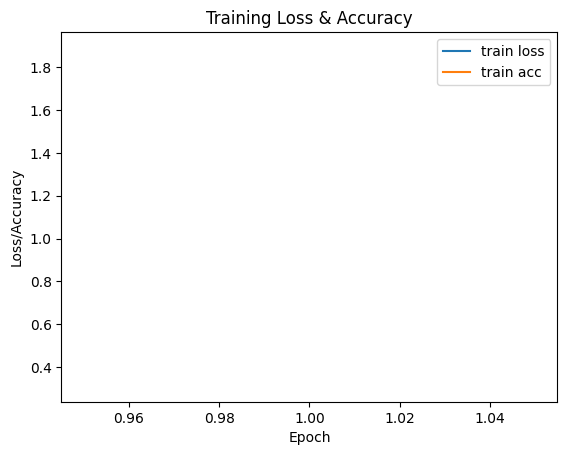

In [10]:
def plot(trainloss, trainacc):
    plt.figure()
    plt.plot(range(1, len(trainloss)+1),trainloss, label="train loss")
    plt.plot(range(1, len(trainacc)+1),trainacc, label="train acc")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.title("Training Loss & Accuracy")
    plt.show()
    
print(trainloss)

plot(trainloss, trainacc)

In [11]:
#tensorboardを使ってみよう
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [12]:
#tensorboardを用いた訓練関数


experiment_name = f"experiment_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
log_dir = f"runs/{experiment_name}"
writer = SummaryWriter(log_dir=log_dir)
model = NN()

# モデルのグラフを記録
dummy_input = torch.randn(1, 3, 32, 32)  # CIFAR-10 の場合
writer.add_graph(model, dummy_input)


def train(model, trainloader, criterion, optimizer, num_epochs=5, device="cpu"):
    global trainacc, trainloss
    trainloss = []
    trainacc = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = correct / total
        trainloss.append(epoch_loss)
        trainacc.append(epoch_acc)
        
        # TensorBoard に記録
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Accuracy/train", epoch_acc, epoch)
        
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.2%}")
    writer.close()
    print("training finished")

In [13]:
#訓練してみる。

dataiter = iter(trainloader)
images, labels = next(dataiter)
writer.add_images("Train Images", images)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, trainloader, criterion, optimizer, num_epochs=5, device="cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/5 - Loss: 1.8611 - Accuracy: 32.48%
Epoch 2/5 - Loss: 1.6819 - Accuracy: 39.46%
Epoch 3/5 - Loss: 1.6078 - Accuracy: 42.63%
Epoch 4/5 - Loss: 1.5653 - Accuracy: 43.81%
Epoch 5/5 - Loss: 1.5258 - Accuracy: 45.77%
training finished
